# Miscellaneous util

> Miscellaneous util code

In [ ]:
#| default_exp utils.misc_utils

In [ ]:
#| export
from genQC.imports import *
import gc, traceback, inspect

## Memory utils

In [ ]:
#|export
class MemoryCleaner():
    """CLass with static methods to clean (gpu) memory."""
    
    @staticmethod
    def _clean_ipython_hist():
        # Code in this function mainly copied from IPython source
        if not 'get_ipython' in globals(): return
        ip = get_ipython()
        user_ns = ip.user_ns
        ip.displayhook.flush()
        pc = ip.displayhook.prompt_count + 1
        for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
        user_ns.update(dict(_i='',_ii='',_iii=''))
        hm = ip.history_manager
        hm.input_hist_parsed[:] = [''] * pc
        hm.input_hist_raw[:] = [''] * pc
        hm._i = hm._ii = hm._iii = hm._i00 =  ''

    @staticmethod
    def _clean_tb():
        if hasattr(sys, 'last_traceback'):
            traceback.clear_frames(sys.last_traceback)
            delattr(sys, 'last_traceback')
        if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
        if hasattr(sys, 'last_value'): delattr(sys, 'last_value')
        
    @staticmethod
    def purge_mem():
        """Clear all. Purge all memory."""
        MemoryCleaner._clean_tb()
        MemoryCleaner._clean_ipython_hist()
        gc.collect()
        torch.cuda.empty_cache()   
        
    @staticmethod
    def free_memory(to_delete: list):
        """Remove objs of `to_delete` from namespace"""
        calling_namespace = inspect.currentframe().f_back
        for _var in to_delete:
            del _var
            calling_namespace.f_locals.pop(_var, None)
            gc.collect()
            torch.cuda.empty_cache()

## Python utils

In [ ]:
#| export
def virtual(f: callable) -> callable:
    '''Decorator to enfore subclass method implementations and raises error at method calls.'''
    @functools.wraps(f)
    def inner(self, *args, **kwargs): raise NotImplementedError(f"Virtual method {f.__name__} needs to be implemented by subclass {self.__class__.__name__}.")      
    return inner

In [ ]:
class A():
    def p1(self, x): print("A p1", x)
    
    @virtual
    def p2(self, x): pass
 
class B(A):
    def p3(self, x): print("B p2", x)
    
b = B()
b.p1(1)
try:
    b.p2(1)
except BaseException as e:
    print("Exception that would be raised: ", e)

A p1 1
Exception that would be raised:  Virtual method p2 needs to be implemented by subclass B.


In [ ]:
#| export
def cache_data(file_name, force_recompute):
    """
    A decorator that memorizes the result of a function and stores it.
    Note, if the function or its arguments change we ignore it, we only check if the file exists!

    Parameters:
        - file_name (str): The name of the file to store the memoized results.
        - force_recompute (bool): If True, existing cache is ignored.
    """
        
    #-------------------
    def load(): 
        if os.path.exists(file_name) and not force_recompute: 
            return torch.load(file_name)
        return None
    
    #-------------------
    def save(cache):     
        if exists(cache): 
            os.makedirs(file_name[:file_name.rfind("/")] + "/", exist_ok=True)
            torch.save(cache, file_name)
    
    #-------------------
    def decorator(func: callable) -> callable: 
        @functools.wraps(func)
        def inner(*args, **kwargs):
        
            cache = load()
            
            if not exists(cache): # run function normally
                print(f"Computing: {func.__name__}")
                cache = func(*args, **kwargs)
                
                save(cache)
                print(f"Result saved")
                
            else: # loaded already from cache
                print(f"Result retrieved from cache: {func.__name__}")
            
            return cache
        return inner
    return decorator

## Torch utils

In [ ]:
#|export
class DataLoaders:
    """Combines train and valid `DataLoader` objects."""
    def __init__(self, *dls: list[DataLoader]): self.train, self.valid = dls[:2]

In [ ]:
#| export
def infer_torch_device(): 
    if torch.cuda.is_available():   
        torch.backends.cudnn.benchmark = True

        dev_cap = torch.cuda.get_device_capability()
        
        if dev_cap[0] >= 8: # AMPERE and up
            print(f"[INFO]: Cuda device has a capability of {dev_cap[0]}.{dev_cap[1]} (>= 8), allowing tf32 matmul.")
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
        
        return torch.device("cuda")
    return torch.device("cpu")

In [ ]:
infer_torch_device()

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.


device(type='cuda')

In [ ]:
#| export
def number_of_paramters(model: nn.Module): return sum([p.flatten().shape[0] for p in model.parameters()])

In [ ]:
#| export
def normalize_tensor(t: torch.Tensor):
    """[0,1] to [-1,1]"""
    return t * 2.0 - 1.0

def scale_tensor(t: torch.Tensor):
    """[-1,1] to [0,1]"""
    return (t / 2.0 + 0.5).clamp(0.0, 1.0)

## Plot utils

In [ ]:
#| export
def savePdf(filename): plt.savefig(filename + '.pdf', bbox_inches='tight')
def savePng(filename): plt.savefig(filename + '.png', bbox_inches='tight')
def saveSvg(filename): plt.savefig(filename + '.svg', bbox_inches='tight')

In [ ]:
#| export
def plot_image_grid(imgs: Union[list, np.array, torch.Tensor], labels: list=None, labels_fs="medium", 
                    figsize=(16, 4), cols=8, cmap="Greys", show_colorbar=False, **imshow_kwargs):  
    if type(imgs) is list: n = len(imgs)
    elif type(imgs) is np.ndarray: n = imgs.shape[0]
    elif type(imgs) is torch.Tensor: n = imgs.shape[0]
    else: raise NotImplementedError("err type:", type(imgs))

    if n == 0: return

    cols = min(n, cols)
    rows = math.ceil(n/cols)

    fig, axs = plt.subplots(rows, cols, figsize=figsize, squeeze=False, constrained_layout=True)   
    for i, (r, c) in enumerate(itertools.product(range(rows), range(cols))):
        plt.sca(axs[r,c])
        plt.axis('off')
         
        if i >= n: continue

        if labels is not None: plt.title(labels[i], fontsize=labels_fs)
        p = plt.imshow(imgs[i], cmap=cmap, **imshow_kwargs) #cmap ignored for RGB   
        if show_colorbar: plt.colorbar(p)
        
    plt.show()

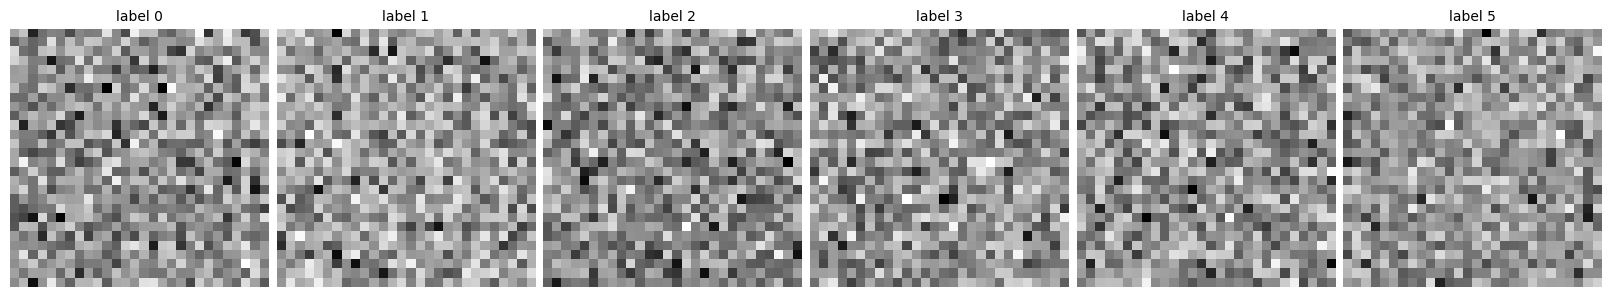

In [ ]:
n = 6
plot_image_grid(torch.randn((n,28,28,1)), [f"label {i}" for i in range(n)])

In [ ]:
#| export
def latents_to_pil(latents:torch.Tensor, channels=None):
    if channels is None:        
        channels = latents.shape[1] if len(latents.shape) > 3 else 1
            
    images = scale_tensor(latents)
    images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
    
    if channels == 1: images = images[:, :, :, 0]

    images = (images * 255).round().astype(np.uint8)
  
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images   

## Inference utils

In [ ]:
#| export
def set_seed(seed: int):
    """Sets a seed to pytorch, numpy and python. Additionally sets cuda flags."""

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # see https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True)

    # see https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [ ]:
#| export
def get_element_matching_indices(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """Compares (2d) `a` with `b`. Returns the indices of `b`, where a element of `a` matches with `b`."""
    # Expand dimensions of a to match the shape of b for element-wise comparison
    expanded_a = a.unsqueeze(0).expand(b.shape[0], *a.shape)  # [b0, a0, a1]
    expanded_b = b.unsqueeze(1)                               # [b0,  1, b1]
    
    # Compare all vector entries of a with all vectors of b
    matches = torch.all(expanded_a == expanded_b, dim=-1)

    matching_indices = torch.nonzero(torch.any(matches, dim=1)).squeeze()
    
    if matching_indices.dim() == 0: matching_indices = torch.tensor([matching_indices])

    return matching_indices

In [ ]:
#| export
def get_entanglement_bins(num_of_qubits: int) -> Tuple[List[List], List[str]]:
    """Returns all SRV sorted in entangle bins, corresponding to a number of entangled qubits."""
    
    dist_srvs = [x for x in itertools.product(*([[1,2]]*num_of_qubits))]
    dist_srvs = np.array(dist_srvs, dtype=int)[np.sum(dist_srvs, axis=1)!=num_of_qubits+1].tolist()
    dist_srvs = sorted(dist_srvs, key=lambda x: sum(x))
    dist_srvs = np.array(dist_srvs)
    
    entangle = [1] + [scipy.special.comb(num_of_qubits, i, exact=True) for i in range(2, num_of_qubits)]
    
    entanglement_bins = np.split(dist_srvs, np.cumsum(entangle))
    
    ent_bits = [f"{sum(n[0])-num_of_qubits} qubit entangled" for n in entanglement_bins]
    
    return [x.tolist() for x in entanglement_bins], ent_bits

Print the Schmidt-rank-vector bins for 5 qubits:

In [ ]:
for srvs,label in zip(*get_entanglement_bins(5)):
    print(label, ":", srvs)

0 qubit entangled : [[1, 1, 1, 1, 1]]
2 qubit entangled : [[1, 1, 1, 2, 2], [1, 1, 2, 1, 2], [1, 1, 2, 2, 1], [1, 2, 1, 1, 2], [1, 2, 1, 2, 1], [1, 2, 2, 1, 1], [2, 1, 1, 1, 2], [2, 1, 1, 2, 1], [2, 1, 2, 1, 1], [2, 2, 1, 1, 1]]
3 qubit entangled : [[1, 1, 2, 2, 2], [1, 2, 1, 2, 2], [1, 2, 2, 1, 2], [1, 2, 2, 2, 1], [2, 1, 1, 2, 2], [2, 1, 2, 1, 2], [2, 1, 2, 2, 1], [2, 2, 1, 1, 2], [2, 2, 1, 2, 1], [2, 2, 2, 1, 1]]
4 qubit entangled : [[1, 2, 2, 2, 2], [2, 1, 2, 2, 2], [2, 2, 1, 2, 2], [2, 2, 2, 1, 2], [2, 2, 2, 2, 1]]
5 qubit entangled : [[2, 2, 2, 2, 2]]


# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()